# Garbage Classification - CNN

The **Garbage Classification Dataset** contains images categorized into six classes:  
1. **Cardboard**: 393 images  
2. **Glass**: 491 images  
3. **Metal**: 400 images  
4. **Paper**: 584 images  
5. **Plastic**: 472 images  
6. **Trash**: 127 images  

### Objective
The goal of this project is to use a Convolutional Neural Network (CNN) and Transfer Learning to differentiate between these six classes of garbage. The dataset is sourced from **Keras**, which provides access to preprocessed datasets for machine learning projects.

### Usefulness
Garbage classification can be extremely useful in:  
- **Recycling centers**: Automatically sorting recyclable materials like paper, glass, metal, and plastic.  
- **Smart waste management systems**: Implementing AI-powered garbage bins that classify waste in real time.  
- **Environmental protection**: Reducing manual labor and errors in waste segregation, ultimately improving recycling efficiency.  

### Potential Applications
- **IoT-powered smart bins** for homes and public spaces.  
- **Automated conveyor systems** in waste management facilities.  
- Enhancing **environmental research** by tracking the types and quantities of waste generated in different areas.  


## Importing libraries


In [74]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, save_model
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten, Dropout, 
    GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping


## Load and show the data

In [3]:
base_dir = os.getcwd()
dir = os.path.join(base_dir, "data", "Garbageclassification", "Garbageclassification")
classes=["cardboard","glass","metal","paper","plastic","trash"]

In [4]:
def load_data(path,size):
    images = []
    labels = []
    class_names = []
    
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size)
                    images.append(img)
                    labels.append(classes.index(class_name))
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [5]:
imgs_data,labels_data = load_data(dir,(224,224))

In [6]:
print(imgs_data.shape,labels_data.shape)

(2527, 224, 224, 3) (2527,)


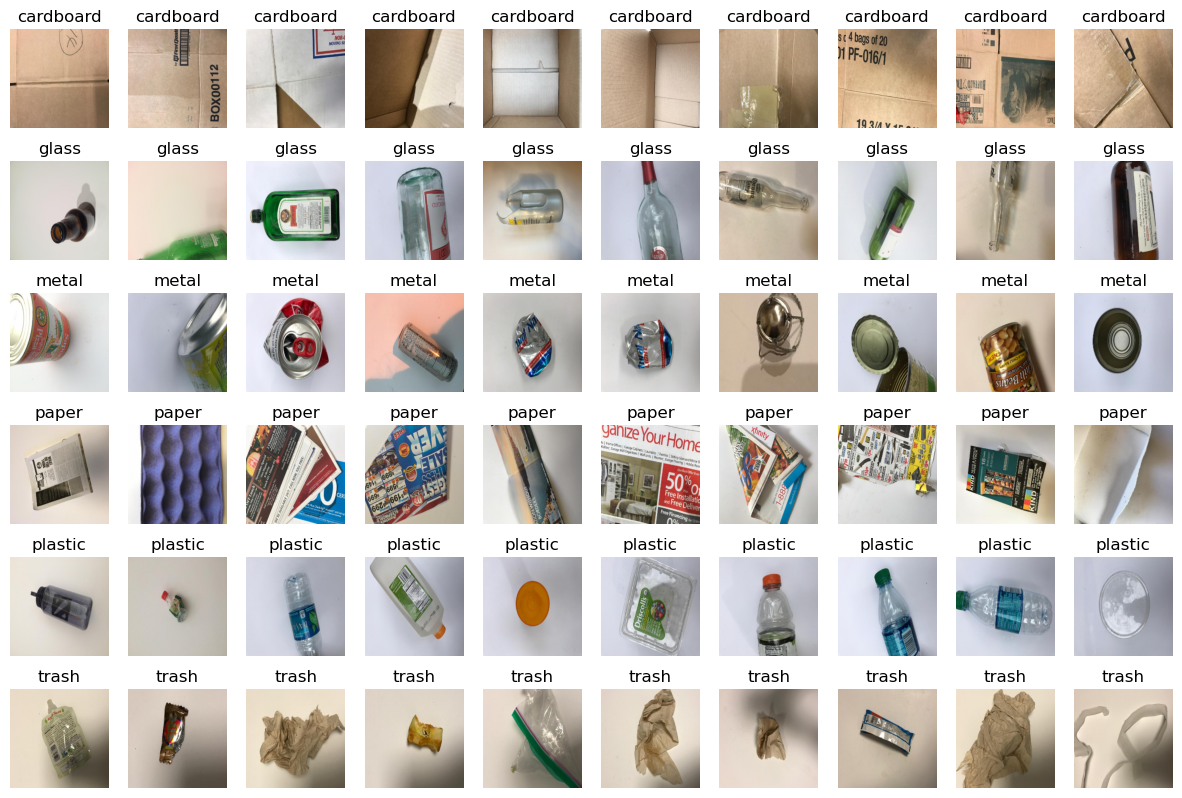

In [77]:
def show_images_from_loaded_data(images, labels, classes, num_images=10):
    plt.figure(figsize=(15, 10)) 
    
    idx = 0 
    for class_name in classes:
        class_indices = np.where(labels == classes.index(class_name))[0]
        for i, class_idx in enumerate(class_indices[:num_images]):
            plt.subplot(len(classes), num_images, idx + 1)  
            plt.imshow(cv2.cvtColor(images[class_idx], cv2.COLOR_BGR2RGB)) 
            plt.axis('off') 
            plt.title(class_name) 
            idx += 1

    plt.show()

show_images_from_loaded_data(imgs_data, labels_data, classes, num_images=10)

## Apply augmentation to the dataset

In [79]:
# Define the image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images in the range 0-20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by 20% of the height
    shear_range=0.2,           # Randomly shear images
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in newly created pixels after rotation or shift
)

# Augment the dataset
augmented_images = []
augmented_labels = []

augmentation_count = int(len(imgs_data))

for img, label in zip(imgs_data, labels_data):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        augmented_labels.append(label)
        i += 1
        if i >= (augmentation_count / len(imgs_data)):
            break

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine the original and augmented data
final_imgs_data = np.concatenate((imgs_data, augmented_images), axis=0)
final_labels_data = np.concatenate((labels_data, augmented_labels), axis=0)

In [81]:
print("Size before augmentation : ",imgs_data.shape[0])
print("Size After augmentation : ",final_imgs_data.shape[0])

Size before augmentation :  2527
Size After augmentation :  5054


## Split the data

In [83]:
# Split data into training+validation (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(final_imgs_data, final_labels_data, test_size=0.2, random_state=42)

## Transfer Learning with MobileNetV2

### Normalize Data

In [16]:
# Normalize your image data
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

### Define the MobileNetV2 model

In [52]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

### Freeze the base model

In [53]:
base_model.trainable = False

### Create a new model on top

In [54]:
model1 = Sequential([
    base_model,
    Flatten(),  # Flatten the output of the base model
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # assuming classification task
])


### Compile the model

In [55]:
model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

### Define early stopping callback

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Train the model

In [57]:
# Train the model with early stopping
history = model1.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 129s 601ms/step - loss: 0.9453 - sparse_categorical_accuracy: 0.6442 - val_loss: 0.5008 - val_sparse_categorical_accuracy: 0.8164
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 121s 597ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9417 - val_loss: 0.3910 - val_sparse_categorical_accuracy: 0.8511
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 120s 593ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.3590 - val_sparse_categorical_accuracy: 0.8721
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 117s 576ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.3447 - val_sparse_categorical_accuracy: 0.8801
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 114s 564ms/step - loss: 0.0041 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.3769 - val_sparse_categorical_accuracy: 0.8721
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 115s 568ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.3685 - val_sparse_categoric

### Evaluate the model

In [58]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 426ms/step - loss: 0.3251 - sparse_categorical_accuracy: 0.9049
Test accuracy: 0.909990131855011


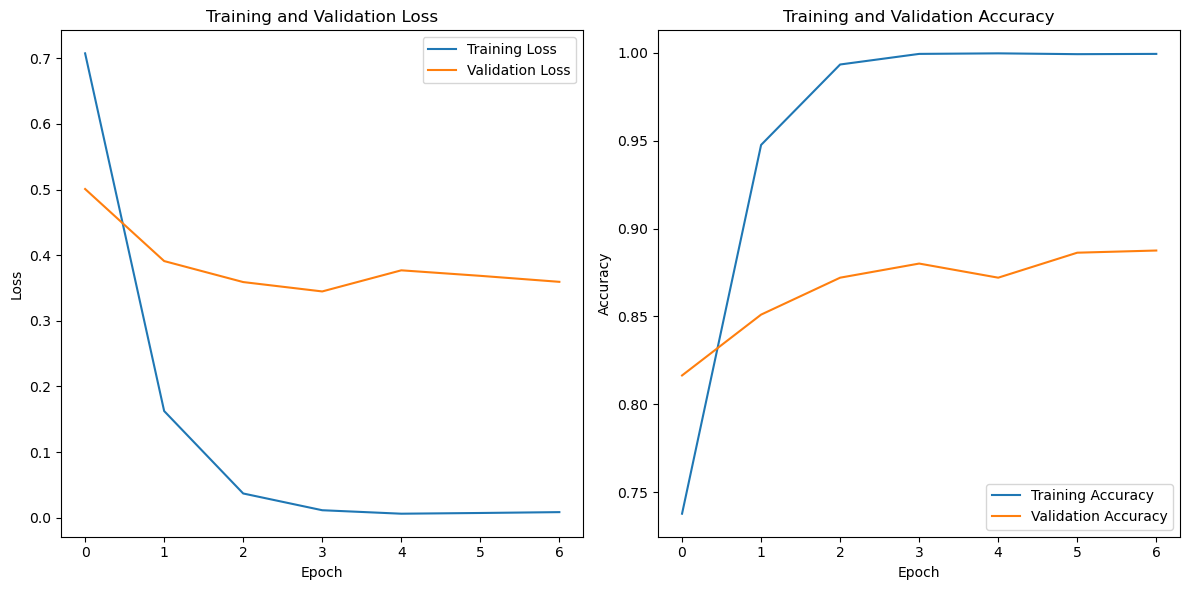

In [59]:
# Extracting history from training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Transfer Learning with VGG16

In [8]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [9]:
# summary of convolution base of VGG16 model
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Initialize a sequential model to group a linear stack of layers
model2 = Sequential()

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model2.add(base_model)

# add global average pooling layer
model2.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model2.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model2.add(BatchNormalization())                 # normalize and scale inputs or activations
model2.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model2.add(Dense(units=128, activation='relu')) # use ReLU activation function
model2.add(BatchNormalization())                # normalize and scale inputs or activations
model2.add(Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model2.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions

In [12]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [17]:
history = model2.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=16)

Epoch 1/5
171/203 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 2.1009 - sparse_categorical_accuracy: 0.2911

KeyboardInterrupt: 

## CNN

In [86]:
# Adjust the Dense layer input based on the correct flattened size
model1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(6, activation='softmax')
])


C:\Users\lozan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [88]:
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])


In [90]:
history = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
 14/127 ━━━━━━━━━━━━━━━━━━━━ 4:49 3s/step - accuracy: 0.2657 - loss: 2.9368

KeyboardInterrupt: 

In [ ]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))  # 32 filters, 3x3 kernel
model2.add(Dropout(0.2))  # Dropout for regularization

# Second Convolutional Block
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # 64 filters, 3x3 kernel
model2.add(MaxPooling2D())  # Pooling layer to downsample the feature maps
model2.add(Dropout(0.3))  # Dropout for regularization

# Flatten and Fully Connected Layers
model2.add(Flatten())  # Flatten the feature maps into a 1D vector
model2.add(Dense(256, activation='relu'))  # Fully connected layer with 256 neurons
model2.add(Dropout(0.5))  # Dropout to reduce overfitting

# Output Layer
model2.add(Dense(6, activation='softmax'))


In [ ]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels, use sparse categorical cross-entropy
              metrics=['accuracy'])

In [ ]:
history = model2.fit(
    X_train,                      # Training data
    y_train,                      # Training labels
    epochs=10,                    # Number of epochs
    batch_size=32,                # Batch size
    validation_data=(X_test, y_test),  # Validation data
)

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
